In [1]:
import cv2
import numpy as np
import glob
import seaborn as sns
from sklearn.ensemble import IsolationForest
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math

In [2]:
count_img = 0 

Questa funzione prende in ingresso l'immagine originale, l'immagine ritagliata e il nome del salvataggio. Restituisce un immagine che rappresenta la zona di lavoro

In [3]:
def cutWorkSpace(img,border): 
    # dimensioni immagini
    img_h = 2048
    img_l = 2048
    # offset per posizionamento su area d'indagine
    offset_x = 600
    offset_y = 500
    
    #taglio per garantire la ricerca sull'area di interesse, evitando rumori dati dallo sfondo
    crop_img = img[offset_y:img_h-offset_y, offset_x:img_l-offset_x]
    
    # Convert the img to grayscale
    gray = cv2.cvtColor(crop_img,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    high_thresh, thresh_im = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #cv2.imwrite('provaT.jpg', thresh_im)
    lowThresh = 0.5*high_thresh
    
    
    # Apply edge detection method on the image
    #edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    #cv2.imwrite('results_img/'+str(count_img)+'ed.jpg', edges)
    #cv2.imwrite('canny.jpg', edges)
    # This returns an array of r and theta values
    lines = cv2.HoughLines(edges,1,np.pi/180, 100)
    #cv2.imwrite('Risultati/resFS'+name+'c.jpg', edges)
    # The below for loop runs till r and theta values 
    # are in the range of the 2d array
    i = 0
    x_first = 0
    x_second = 0
    count = 0
    delta = 30
    thetaFinal = 0
    while count < 2:
        for r,theta in lines[i]:
            # Stores the value of cos(theta) in a
            a = np.cos(theta)

            # Stores the value of sin(theta) in b
            b = np.sin(theta)

            # x0 stores the value rcos(theta)
            x0 = a*r

            # y0 stores the value rsin(theta)
            y0 = b*r

            #ti define line lenght
            const = 3000
            # x1 stores the rounded off value of (rcos(theta)-1000sin(theta))
            x1 = int(x0 + const*(-b))

            # y1 stores the rounded off value of (rsin(theta)+1000cos(theta))
            y1 = int(y0 + const*(a))

            # x2 stores the rounded off value of (rcos(theta)+1000sin(theta))
            x2 = int(x0 - const*(-b))

            # y2 stores the rounded off value of (rsin(theta)-1000cos(theta))
            y2 = int(y0 - const*(a))

            if count == 0 :
                if theta != 0:
                    thetaFinal = 180-math.degrees(theta)
                x_first = x0
                #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                count += 1
            else:
                if abs(x_first-x0) > delta :
                    x_second = x0
                    #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                    count += 1
            i += 1
    # All the changes made in the input image are finally
    # written on a new image houghlines.jpg
    #cv2.imwrite('Risultati/res'+name+'.jpg', img)
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # rotate our image by Theta degrees around the center of the image
    M = cv2.getRotationMatrix2D((cX, cY), -thetaFinal, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h))
    scale_percent = 100 # percent of original size

  
    if x_first < x_second:
        
        median = (x_second+x_first)//2
        temp = rotated[0:img_h-1, int(offset_x+median-border):int(offset_x+median+border)]
        width = int(temp.shape[1] * scale_percent / 100)
        height = int(temp.shape[0] * scale_percent / 100)
        dim = (width, height)
        temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)        
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        return  gray
    else:
        median = (x_first+x_second)//2.
        temp = rotated[0:img_h-1, int(offset_x+median-border):int(offset_x+median+border)]        
        #blurred = cv2.GaussianBlur(temp, (3,3), 0)
        width = int(temp.shape[1] * scale_percent / 100)
        height = int(temp.shape[0] * scale_percent / 100)
        dim = (width, height)
        temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        return  gray
    

In [4]:
def divideImage(img,lung):
    results = []
    
    for i in range(2048// lung):
        results.append(img[(lung*i):(lung*(i+1))][:])

    return results

In [5]:
def create_PCA(image_arrays,components):
    
    x = image_arrays

    scaler.fit(x)
    x = scaler.transform(x)

    pca = PCA(n_components=components)
    principalComponents = pca.fit_transform(x)

    return principalComponents, pca

In [6]:
def use_PCA(image_arrays,pca):
    
    x = image_arrays

    x = scaler.transform(x)

    principalComponents = pca.transform(x)

    return principalComponents

In [7]:
## creazione array da immagine
def createNN(imgsWithClass):
    
    # creo histogramma con valori trovati di feature per ogni immagine di train
    train_imgs = imgsWithClass[0]
    res = []
    k = 0
    for img in train_imgs:
        im = []
        for d in img:
            for i in d:
                im.append(i)
        im.append(imgsWithClass[1][k])
        k += 1
        res.append(im)
    
    res = np.array(res)
    
    
    ####################################################################
    ###  Qua devo usare la PCA creata per ridurre la dimensionalità  ###
    ####################################################################
    
    
    
    return res
    #return kmeans, mlp, val_result

In [8]:
## creazione array da immagine
def createNN_2(imgsWithClass):
    
    # creo histogramma con valori trovati di feature per ogni immagine di train
    train_imgs = imgsWithClass
    res = []
    k = 0
    for img in train_imgs:
        im = []
        for d in img:
            for i in d:
                im.append(i)
        k += 1
        res.append(im)
    
    res = np.array(res)
    
    
    ####################################################################
    ###  Qua devo usare la PCA creata per ridurre la dimensionalità  ###
    ####################################################################
    
    
    
    return res
    #return kmeans, mlp, val_result

In [9]:
## data un'immagine creo l'array e fitto il modello 

def testNN(train_imgs):
    
    results=[]
    
    res = []
    for img in train_imgs:
        im = []
        for d in img:
            for i in d:
                im.append(i)
        res.append(im)
    
    res = np.array(res)
    
    ####################################################################
    ###  Qua devo usare la PCA creata per ridurre la dimensionalità  ###
    ####################################################################
    
    cols = []
        
    for i in range(len(res[0])):
        cols.append('F'+str(i+1))


    df = pd.DataFrame(res ,columns = cols)
    results.append(model.predict(df[cols]))

    return results

In [10]:
def scale_image(img,scale_percent):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)    

85
7514
0.011312217194570135


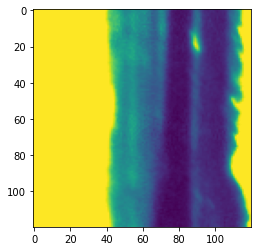

In [11]:
scelta = 120
threshold = 5
if scelta == 70:
    pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni70/*.tif'
    pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni70Val/*.tif'
    contamination_N = 6/79.

if scelta == 100:
    pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni100/*.tif'
    pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni100Val/*.tif'
    contamination_N = 6/107.
if scelta == 120:
    pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni120/*.tif'
    pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni120Val/*.tif'
    contamination_N = 6/126.

pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
pathScarti = '/Users/leonardoaggio/Desktop/Dataset/Dataset/SectionScarti/*.tif'

pathFSVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScartiVal/*.tif'
pathScartiVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/*.tif'



scaler = StandardScaler() 
pca_componenets = 10
lunghezza_sezione_immagine = 120
border = 60
reduction = 30
#
#
pezziXimmagine = 2048 // lunghezza_sezione_immagine

results = []
img_results = []
list_paths = []

list_paths_scarti = glob.glob(pathScarti)
results += [1] * len(glob.glob(pathScarti)) * pezziXimmagine

temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'
pathBuoni = temp

list_paths = glob.glob(pathBuoni) 
results += [0] * len(glob.glob(pathBuoni)) * pezziXimmagine


#list_paths += glob.glob(pathFS)
#results += [0] * len(glob.glob(pathFS)) * pezziXimmagine


#list_paths += glob.glob(pathBuoniVal) 
#results += [0] * len(glob.glob(pathBuoniVal)) * pezziXimmagine

#list_paths += glob.glob(pathFSVal)
#results += [0] * len(glob.glob(pathFSVal)) * pezziXimmagine

#list_paths += glob.glob(pathScartiVal)
#results += [1] * len(glob.glob(pathScartiVal)) * pezziXimmagine



for img_path in list_paths_scarti:
    img = cv2.imread(img_path)
    #plt.imshow(img)
    #plt.show()
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #plt.imshow(img)
    #plt.show()
    img_results.append(img)
    
    
    
imgs_for_PCA = []
#print(results)
i = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    #cv2.imwrite('ImgScarte/img'+str(i)+'.jpg', temp)
    temp2 = divideImage(temp,lunghezza_sezione_immagine)
    img_results += temp2
    imgs_for_PCA += temp2
    #j = 0
    #for im in temp2:
    #cv2.imwrite('results_img/'+str(count_img)+'.jpg', temp)
    #j += 1
    i += 1
    count_img += 1
    
contamination_N = (len(list_paths_scarti)) / (len(img_results) )

print(len(list_paths_scarti))
print(len(img_results))

print(contamination_N)
    
plt.imshow(img_results[1])
plt.show()

In [12]:
print(contamination_N)

0.011312217194570135


In [13]:
## creazione PCA

temp = []

for img in imgs_for_PCA:
    temp.append(scale_image(img,reduction))
    
imgs_for_PCA = temp

    
array_PCA = np.array(imgs_for_PCA)
array_PCA = array_PCA/255.



In [14]:
array_PCA = createNN_2(array_PCA)


principalComponents, pca = create_PCA(array_PCA,pca_componenets)



In [15]:
temp = []

for img in img_results:
    temp.append(scale_image(img,reduction))
    

In [16]:
img_results = temp

In [17]:
train_images = np.array(img_results)
train_images = train_images/255.

In [18]:
imgsWithClass = [train_images,results]


histo_t = createNN_2(imgsWithClass[0])

histo = use_PCA(histo_t,pca)

In [19]:
import pandas as pd

cols = []
hist_2 = []
i = 0




for i in range(len(histo[0])):
    cols.append('F'+str(i+1))


df = pd.DataFrame(histo ,columns = cols)



In [20]:
df

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10
0,-39.542120,17.136618,66.536307,12.326790,96.253392,-9.240546,31.108874,-40.316392,-12.827036,-16.790330
1,-36.960528,13.025525,64.619807,11.506706,87.272070,-14.883597,27.648999,-47.215668,-18.617401,-18.732593
2,22.904591,40.427837,-8.523055,4.268164,6.884444,-9.324602,0.691203,-0.956930,4.562535,-0.088933
3,16.940048,36.447807,-13.189073,-4.796980,12.551928,-15.095284,-4.331258,-0.903479,10.987497,-6.420667
4,-33.517841,20.572902,50.359911,13.198039,82.258290,-14.367979,21.994422,-37.477857,-10.627691,-19.500857
...,...,...,...,...,...,...,...,...,...,...
7509,11.716026,-17.592020,3.544796,-13.357673,1.202370,-4.347085,2.972406,2.878913,3.697751,-2.289632
7510,14.575243,-16.425459,-3.020942,-13.518215,2.049597,1.587787,8.997390,1.069934,1.213380,-6.107179
7511,15.883694,-12.381508,-5.179828,-11.950452,2.987873,2.036911,8.324842,-0.575236,-1.728536,-3.177945
7512,18.001067,-10.122239,-1.170386,-12.196098,1.869029,0.372101,4.988836,-0.902238,-0.456067,0.304050


In [21]:
#sns.boxplot(histo[0])

In [22]:
random_state = np.random.RandomState(42)

In [23]:
col = []

for i in range(len(histo[0])):
    col.append('F'+str(i+1))

model=IsolationForest(n_estimators=100,verbose = 1,max_samples='auto',contamination=contamination_N,random_state=random_state)

model.fit(histo)

print(model.get_params())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


{'bootstrap': False, 'contamination': 0.011312217194570135, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': RandomState(MT19937) at 0x7F9641F56050, 'verbose': 1, 'warm_start': False}


In [24]:
df['scores'] = model.decision_function(df[col])

df['anomaly_score'] = model.predict(df[col])

df[df['anomaly_score']==-1]

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,scores,anomaly_score
0,-39.542120,17.136618,66.536307,12.326790,96.253392,-9.240546,31.108874,-40.316392,-12.827036,-16.790330,-0.089319,-1
1,-36.960528,13.025525,64.619807,11.506706,87.272070,-14.883597,27.648999,-47.215668,-18.617401,-18.732593,-0.098788,-1
4,-33.517841,20.572902,50.359911,13.198039,82.258290,-14.367979,21.994422,-37.477857,-10.627691,-19.500857,-0.082185,-1
7,-37.191480,21.164373,47.239008,4.150828,61.639196,-23.501088,29.016765,-43.983122,-12.923798,-15.317950,-0.095131,-1
8,-38.906895,19.014163,51.468945,4.285233,57.064498,-26.871510,32.131033,-47.881886,-15.894695,-17.326052,-0.099986,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
4605,11.923722,-7.854604,40.943475,-5.690364,23.499365,-24.803948,22.000557,-34.890915,-7.934998,1.559951,-0.010397,-1
4606,16.993259,-9.103467,30.537941,-18.295621,8.814403,-18.567904,28.888392,-20.512904,1.486761,9.673994,-0.015700,-1
4894,-29.551317,11.973965,30.291429,-2.546623,29.016672,-18.214515,19.096573,-32.635826,-9.836196,-5.768442,-0.009616,-1
5354,-10.601911,-8.427323,28.370988,-28.688880,11.659274,-17.922648,15.574286,-24.552225,-3.698772,9.047920,-0.012014,-1


In [25]:
df

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,scores,anomaly_score
0,-39.542120,17.136618,66.536307,12.326790,96.253392,-9.240546,31.108874,-40.316392,-12.827036,-16.790330,-0.089319,-1
1,-36.960528,13.025525,64.619807,11.506706,87.272070,-14.883597,27.648999,-47.215668,-18.617401,-18.732593,-0.098788,-1
2,22.904591,40.427837,-8.523055,4.268164,6.884444,-9.324602,0.691203,-0.956930,4.562535,-0.088933,0.141152,1
3,16.940048,36.447807,-13.189073,-4.796980,12.551928,-15.095284,-4.331258,-0.903479,10.987497,-6.420667,0.056252,1
4,-33.517841,20.572902,50.359911,13.198039,82.258290,-14.367979,21.994422,-37.477857,-10.627691,-19.500857,-0.082185,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
7509,11.716026,-17.592020,3.544796,-13.357673,1.202370,-4.347085,2.972406,2.878913,3.697751,-2.289632,0.216233,1
7510,14.575243,-16.425459,-3.020942,-13.518215,2.049597,1.587787,8.997390,1.069934,1.213380,-6.107179,0.189644,1
7511,15.883694,-12.381508,-5.179828,-11.950452,2.987873,2.036911,8.324842,-0.575236,-1.728536,-3.177945,0.212747,1
7512,18.001067,-10.122239,-1.170386,-12.196098,1.869029,0.372101,4.988836,-0.902238,-0.456067,0.304050,0.232121,1


In [26]:
threshold = 1

In [27]:
temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
#temp = pathScarti
test_path = glob.glob(temp) 
results = []
i = 0
res = []
img_results = []

for img_path in test_path:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    temp2 = divideImage(temp,lunghezza_sezione_immagine)
    
    
    temp3 = []

    for img_s in temp2:
        temp3.append(scale_image(img_s,reduction))
        
    img_results = temp3
    
    
    train_images = np.array(img_results)
    train_images = train_images/255.
    
    res_2 = createNN_2(train_images)
        
    histo = use_PCA(res_2,pca)
    
    res = [model.predict(histo)]
    
    scarto = 0
    
    
    for el in res:
        for e in el:
            if e == -1:
                scarto += 1
    if scarto < threshold:
        i +=1
    print(img_path)
        
    print(res)
    print(scarto)
print('TRAIN scarti')
print('BUONI : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))

/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 8.tif
[array([ 1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
4
/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 9.tif
[array([-1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
2
/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 2.tif
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 3.tif
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 4.tif
[array([-1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1])]
4
/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 5.tif
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 7.tif
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]

In [28]:
temp = pathScartiVal
#temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
#temp = pathScarti
test_path = glob.glob(temp) 
results = []
i = 0
res = []
img_results = []

for img_path in test_path:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    temp2 = divideImage(temp,lunghezza_sezione_immagine)
    
    
    temp3 = []

    for img_s in temp2:
        temp3.append(scale_image(img_s,reduction))
        
    img_results = temp3
    
    
    train_images = np.array(img_results)
    train_images = train_images/255.
    
    res_2 = createNN_2(train_images)
        
    histo = use_PCA(res_2,pca)
    
    res = [model.predict(histo)]
    
    scarto = 0
    
    
    for el in res:
        for e in el:
            if e == -1:
                scarto += 1
    if scarto < threshold:
        i +=1
    print(img_path)
        
    print(res)
    print(scarto)
print('TRAIN scarti')
print('BUONI : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))

/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/Cam3@00004 8.tif
[array([ 1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
4
/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/Cam3@00004 9.tif
[array([-1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
2
/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/Cam3@00004 10.tif
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
TRAIN scarti
BUONI : 1
Falsi buoni su scarti totali: 0.3333333333333333


In [29]:
#temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
#temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'


temp = pathBuoniVal
test_path = glob.glob(temp) 
results = []
i = 0
res = []
img_results = []

for img_path in test_path:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    temp2 = divideImage(temp,lunghezza_sezione_immagine)
    
    
    temp3 = []

    for img_s in temp2:
        temp3.append(scale_image(img_s,reduction))
        
    img_results = temp3
    
    
    train_images = np.array(img_results)
    train_images = train_images/255.
    
    res_2 = createNN_2(train_images)
        
    histo = use_PCA(res_2,pca)
    
    res = [model.predict(histo)]
    
    scarto = 0
    
    
    for el in res:
        for e in el:
            if e == -1:
                scarto += 1
    if scarto >= threshold:
        i +=1
    #print(img_path)
        
    #print(res)
    print(scarto)
print('Buoni validation')
print('Scarti : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))

0
0
0
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
Buoni validation
Scarti : 6
Falsi buoni su scarti totali: 0.0759493670886076


[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


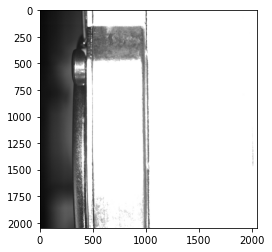

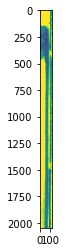

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914943830741.tif
[array([ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1,

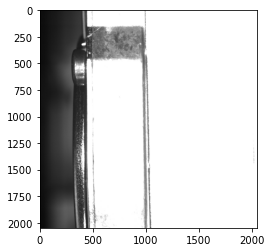

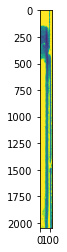

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891151658.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


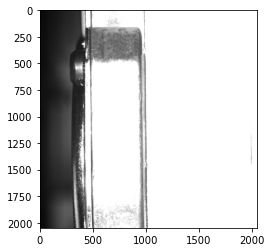

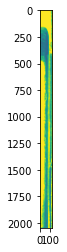

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/72114874942046.tif
[array([-1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
4
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


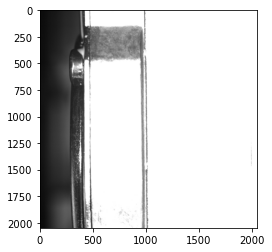

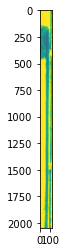

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914943830800.tif
[array([ 1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
4
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


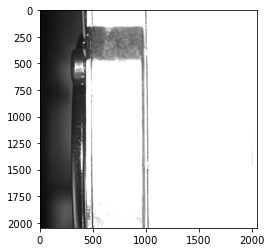

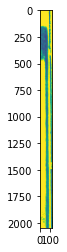

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914943830815.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1])]
8


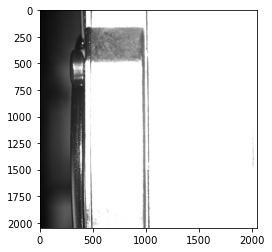

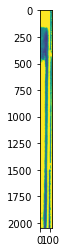

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914943830801.tif
[array([ 1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
2
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1,

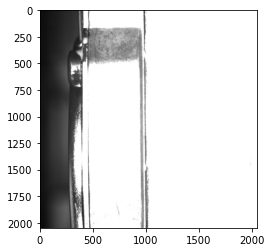

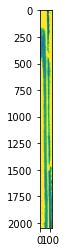

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891152425.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1])]
2


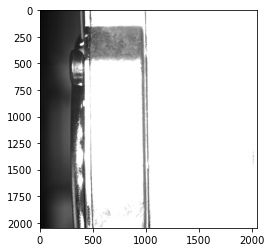

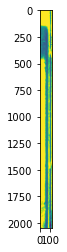

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891152357.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


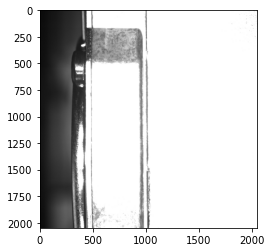

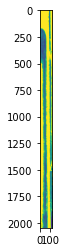

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/72114890993021.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1])]
4
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1,

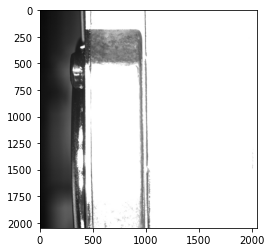

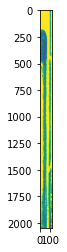

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/72114890993022.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1,

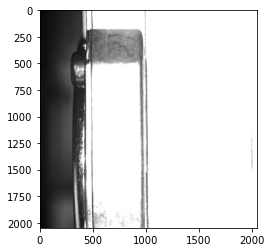

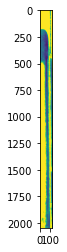

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/72114874942586.tif
[array([ 1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])]
13
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1

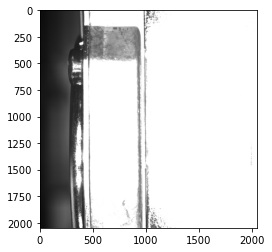

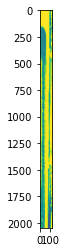

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/72114891012898.tif
[array([-1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1])]
3
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


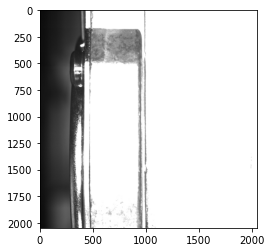

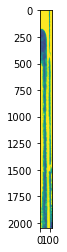

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/72114890993018.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1,

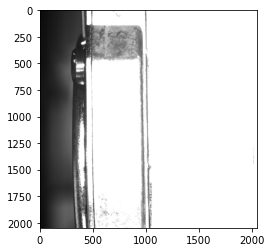

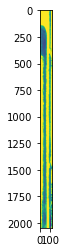

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/72114890993014.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1])]
2
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1,

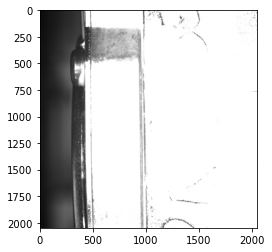

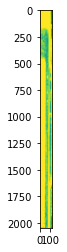

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914547551870.tif
[array([-1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1])]
3
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


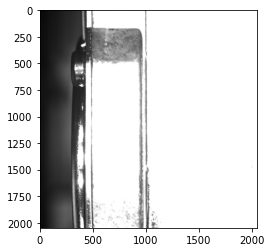

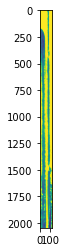

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/72114890993017.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


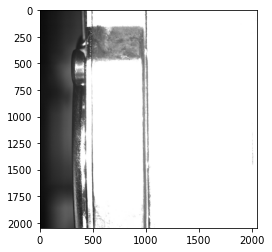

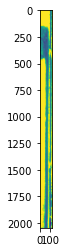

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891152299.tif
[array([-1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


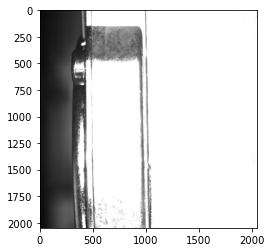

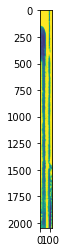

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/72114890993016.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1])]
3
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1,

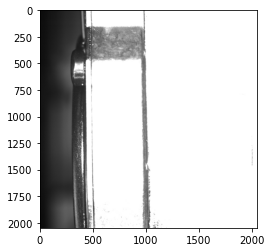

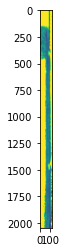

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891151794.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1,

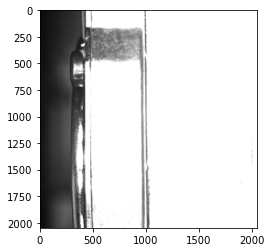

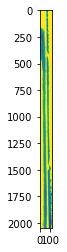

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891152261.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1,

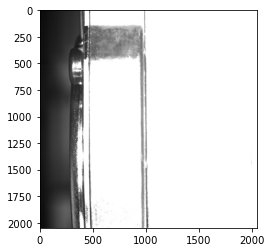

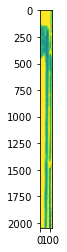

/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/61914891152217.tif
[array([ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
1
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0


In [30]:
#temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'


test_path = glob.glob(temp) 
results = []
i = 0
res = []
img_results = []

for img_path in test_path:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    temp2 = divideImage(temp,lunghezza_sezione_immagine)
    
    
    temp3 = []

    for img_s in temp2:
        temp3.append(scale_image(img_s,reduction))
        
    img_results = temp3
    
    
    train_images = np.array(img_results)
    train_images = train_images/255.
    
    res_2 = createNN_2(train_images)
        
    histo = use_PCA(res_2,pca)
    
    res = [model.predict(histo)]
    
    scarto = 0
    
    
    for el in res:
        for e in el:
            if e == -1:
                scarto += 1
    if scarto >= threshold:
        i +=1
        plt.imshow(img)
        plt.show()
        plt.imshow(temp)
        plt.show()
        print(img_path)
        
    print(res)
    print(scarto)


In [31]:
print(len(test_path))

437


In [32]:
print('TRAIN Buoni')
print('Scarti : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))

TRAIN Buoni
Scarti : 21
Falsi buoni su scarti totali: 0.04805491990846682
